In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns

In [ ]:
df_raw=pd.read_csv('train_ver2.csv')

In [5]:
x=df_raw.groupby('ncodpers').agg({'sexo':len})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002816EC72C50>]],
      dtype=object)

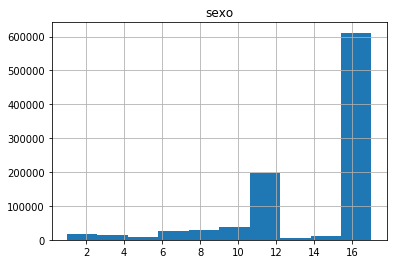

In [6]:
x.hist()

In [8]:
df_raw[df_raw['ncodpers']==15889].sort_values('fecha_dato')

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
416965,2015-01-28,15889,F,ES,V,56,1995-01-16,0.0,245,1.0,...,0,0,0,0,1,1,0,0.0,0.0,0
836224,2015-02-28,15889,F,ES,V,56,1995-01-16,0.0,245,1.0,...,0,0,0,0,0,1,0,0.0,0.0,0
1673961,2015-03-28,15889,F,ES,V,56,1995-01-16,0.0,245,1.0,...,0,0,0,0,0,1,0,0.0,0.0,0
1882060,2015-04-28,15889,F,ES,V,56,1995-01-16,0.0,245,1.0,...,0,0,0,0,0,1,0,0.0,0.0,0
3144382,2015-05-28,15889,F,ES,V,56,1995-01-16,0.0,245,1.0,...,0,0,0,0,1,1,0,0.0,0.0,0
3565837,2015-06-28,15889,F,ES,V,56,1995-01-16,0.0,245,1.0,...,0,0,0,0,1,1,0,0.0,0.0,0
4078996,2015-07-28,15889,F,ES,V,56,1995-01-16,0.0,245,1.0,...,0,0,0,0,1,1,0,0.0,0.0,0
5319234,2015-08-28,15889,F,ES,V,56,1995-01-16,0.0,246,1.0,...,0,0,0,0,0,1,0,0.0,0.0,0
5705188,2015-09-28,15889,F,ES,V,56,1995-01-16,0.0,247,1.0,...,0,0,0,0,0,1,0,0.0,0.0,0
6973298,2015-10-28,15889,F,ES,V,56,1995-01-16,0.0,248,1.0,...,0,0,0,0,0,1,0,0.0,0.0,0


In [ ]:
import xgboost as xgb

In [3]:
def runXGB(train_X, train_y, seed_val=0):
	param = {}
	param['objective'] = 'multi:softprob'
	param['eta'] = 0.05
	param['max_depth'] = 8
	param['silent'] = 1
	param['num_class'] = 22
	param['eval_metric'] = "mlogloss"
	param['min_child_weight'] = 1
	param['subsample'] = 0.7
	param['colsample_bytree'] = 0.7
	param['seed'] = seed_val
	num_rounds = 50

	plst = list(param.items())
	xgtrain = xgb.DMatrix(train_X, label=train_y)
	model = xgb.train(plst, xgtrain, num_rounds)	
	return model


In [57]:
y_var_list=df_raw.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values.tolist()
y_list_new=[i+'_new' for i in y_list]

examine behavior changes since we will only be interested in examining "new" activities 

In [7]:
def examine_behavior(x):
    x=x.astype(int,errors='ignore')
    x=x.diff().fillna(0)
    return ['maintained' if i==0 else 'new' if i==1 else 'dropped' for i in x]

def find_behavior_change(df,y_list,key):
    df[y_list_new]=df[y_list+[key]].groupby(key).transform(examine_behavior)
    return df

In [8]:
df=find_behavior_change(df_raw[df_raw['fecha_dato'].isin(['2015-05-28','2015-06-28'])].copy(),y_var_list,'ncodpers')

NameError: name 'df_raw' is not defined

In [112]:
# convert all users to unique variable
df=df_raw.copy()
ids=list(set(df['ncodpers']))
dict_ids=dict(zip(ids,list(range(0,len(ids)))))
df['ncodpers_val']=df['ncodpers'].apply(lambda x:dict_ids.get(x))
del ids,dict_ids

In [115]:
for c in y_var_list:
    df[c+'_new']=df[c].diff().fillna(0)

df=df.sort_values(['ncodpers_val','fecha_dato'],ascending=[1,1])
df['if_same_person']=df['ncodpers_val'].diff().fillna(-1).apply(lambda x: 1 if x==0 else 0)

df_new=df[df['if_same_person']==1]
print(len(df_new),len(df))

12690664           fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  \
416965    2015-01-28     15889            F              ES    V   56   
836224    2015-02-28     15889            F              ES    V   56   
1673961   2015-03-28     15889            F              ES    V   56   
1882060   2015-04-28     15889            F              ES    V   56   
3144382   2015-05-28     15889            F              ES    V   56   
3565837   2015-06-28     15889            F              ES    V   56   
4078996   2015-07-28     15889            F              ES    V   56   
5319234   2015-08-28     15889            F              ES    V   56   
5705188   2015-09-28     15889            F              ES    V   56   
6973298   2015-10-28     15889            F              ES    V   56   
7450451   2015-11-28     15889            F              ES    V   56   
8617992   2015-12-28     15889            F              ES    V   56   
9401570   2016-01-28     15889            

feature engineering

In [195]:
def pre_process(df):
    print('process indrel_1mes')
    print(df.indrel_1mes.value_counts())

    map_dict = { 1.0  : "1",
                "1.0" : "1",
                "1"   : "1",
                "3.0" : "3",
                "P"   : "0",
                3.0   : "3",
                2.0   : "2",
                "3"   : "3",
                "2.0" : "2",
                "4.0" : "4",
                "4"   : "4",
                "2"   : "2"}
    df.indrel_1mes.fillna("0",inplace=True)
    df.indrel_1mes = df.indrel_1mes.apply(lambda x: map_dict.get(x,x))
    df.indrel_1mes = df.indrel_1mes.astype("category").astype(int)
    
    print('process age')
    df["age"]   = pd.to_numeric(df["age"], errors="coerce")

    print('process getCustSeniority')
    def getCustSeniority(row):
        min_value = 0.
        max_value = 256.
        range_value = max_value - min_value
        missing_value = 0.
        cust_seniority = row['antiguedad'].strip()
        if cust_seniority == 'NA' or cust_seniority == '':
            cust_seniority = missing_value
        else:
            cust_seniority = float(cust_seniority)
            if cust_seniority < min_value:
                cust_seniority = min_value
            elif cust_seniority > max_value:
                cust_seniority = max_value
        return round((cust_seniority-min_value) / range_value, 4)

    df['cust_seniority_updated']=df.apply(lambda row: getCustSeniority(row),axis=1)
    
    df['antiguedad']=df['antiguedad'].astype(int,errors='ignore').fillna(0)
    df['sexo']=df['sexo'].apply(lambda x: 1 if x=='V' else 0)
    return df

In [ ]:
def haha(df):
    with sns.plotting_context("notebook",font_scale=1.5):
        sns.set_style("whitegrid")
        sns.distplot(df["age"].dropna(),
                     bins=80,
                     kde=False,
                     color="tomato")
        sns.plt.title("Age Distribution")
        plt.ylabel("Count")
haha(df)

In [196]:
df_new2=df_new[df_new['fecha_dato']=='2015-05-28']
print(len(df_new2),len(df_new))

628456 12690664


In [197]:
df=pre_process(df_new2)

process indrel_1mes
1.0    624924
3.0         7
Name: indrel_1mes, dtype: int64
process age
process getCustSeniority


In [212]:
vars_selected=['sexo','ind_nuevo','indrel','indrel_1mes','tiprel_1mes','indresi','indext','conyuemp','indfall','tipodom','age','cust_seniority_updated']
X_train=df[vars_selected]

X_train=X_train.select_dtypes(exclude=[np.object]).values

In [214]:
for c in y_list_new:
    df[c]=df[c].apply(lambda x: x if x>=0 else 2)
y_train=df[y_list_new].values

print("Building model..")
model = runXGB(X_train, y_train, seed_val=0)
print("Predicting..")


Building model..
Predicting..


In [215]:
#X_test_raw=pd.read_csv('test_ver2.csv')

xgtest = xgb.DMatrix(X_train)
preds = model.predict(xgtest)

preds

array([[0.8701252 , 0.00629901, 0.00636194, ..., 0.00616915, 0.00616915,
        0.00616915],
       [0.8701252 , 0.00629901, 0.00636194, ..., 0.00616915, 0.00616915,
        0.00616915],
       [0.8701252 , 0.00629901, 0.00636194, ..., 0.00616915, 0.00616915,
        0.00616915],
       ...,
       [0.87033904, 0.00620492, 0.00621335, ..., 0.00617067, 0.00617067,
        0.00617067],
       [0.8703597 , 0.00619382, 0.00620107, ..., 0.00617081, 0.00617081,
        0.00617081],
       [0.87033534, 0.0062049 , 0.00621764, ..., 0.00617064, 0.00617064,
        0.00617064]], dtype=float32)